# Import needed libraries

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from scipy.stats import skew


from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RandomizedLasso
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.decomposition import PCA

from sklearn.feature_selection import RFECV, RFE, f_regression


from sklearn.decomposition import PCA

%matplotlib inline

# Methods used

In [2]:
# Remove correlated columns as this has a big impact on regression
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] >= threshold:
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    return(dataset)

# Load and split the data

In [3]:
user = pd.read_csv("analysis_data.csv", sep=",", index_col="Client")
print(user.shape)

(1566, 41)


In [4]:
user_tr = user[user['Sale_CC']==1]
print(user_tr.shape)

(231, 41)


In [5]:
user_tr = user_tr.drop(['Sale_MF','Sale_CC','Sale_CL','Revenue_MF','Revenue_CL'], axis=1)

In [6]:
print(user_tr.columns)

Index(['Age', 'Tenure', 'M', 'Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD',
       'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF',
       'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred', 'VolumeCred_CA',
       'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb', 'VolumeDeb_CA',
       'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder', 'Revenue_CC', 'Actbal_CA_avg',
       'ActBal_SA_avg', 'ActBal_MF_avg', 'ActBal_OVD_avg', 'ActBal_CC_avg',
       'ActBal_CL_avg'],
      dtype='object')


Outliers are removed from the dataset

In [7]:
user_tr = user_tr.loc[user_tr['Revenue_CC']<30 ]

In [8]:
user_tr_X = user_tr.drop('Revenue_CC', axis=1)
user_tr_Y = user_tr['Revenue_CC']

Highly correlated datasets are removed from the dataset

In [9]:
user_tr_X= correlation(user_tr_X,0.7)

In [10]:
print(user_tr_X.columns)

Index(['Age', 'Tenure', 'M', 'Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD',
       'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF',
       'ActBal_OVD', 'VolumeCred', 'TransactionsCred', 'VolumeDebCash_Card',
       'VolumeDebCashless_Card', 'TransactionsDebCash_Card',
       'TransactionsDeb_PaymentOrder'],
      dtype='object')


In [11]:
user_tr_Y.shape

(220,)

## Correlation

In [12]:
for col in user_tr_X.columns:
    print(col)
    print(np.corrcoef(user_tr_Y,user_tr_X[col])[0][1])

Age
0.0200309612167
Tenure
0.0241065878052
M
0.0407312609358
Count_CA
0.014591496578
Count_SA
-0.0956506020924
Count_MF
-0.0923834325561
Count_OVD
-0.0945015308568
Count_CC
0.00049366672709
Count_CL
0.118820478518
ActBal_CA
0.089914290722
ActBal_SA
-0.0504020474623
ActBal_MF
-0.0806740959744
ActBal_OVD
-0.0461831788373
VolumeCred
0.0155046772756
TransactionsCred
0.00107093771261
VolumeDebCash_Card
-0.0939094228906
VolumeDebCashless_Card
0.0134117118414
TransactionsDebCash_Card
0.01514782769
TransactionsDeb_PaymentOrder
-0.00220972280004


As seen no real correlation exist between the target and one of the remaining variables

# Preprocessing

## check for skewness and log transform if needed

In [13]:
#log transform skewed numeric features:
user_skew = user_tr_X.drop('M', axis=1)
skewed_feats = user_skew.apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

user_tr_X[skewed_feats] = np.log1p(user_tr_X[skewed_feats])

## Check target variable

In [14]:
user_tr_Y.describe()

count    220.000000
mean       5.197672
std        4.566489
min        0.071429
25%        2.130982
50%        4.286786
75%        6.500000
max       28.705000
Name: Revenue_CC, dtype: float64

In [15]:
user_tr_Y.sort_values(ascending = False).head(10)

Client
564     28.705000
908     26.998214
1545    21.207143
618     18.571429
455     18.292143
914     17.310000
203     16.945357
415     16.428571
45      15.393929
575     15.291786
Name: Revenue_CC, dtype: float64

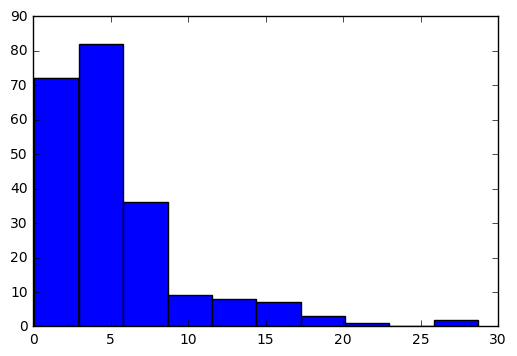

In [16]:
plt.hist(user_tr_Y)
plt.show()

The target will be log transformed for better regression

In [17]:
user_tr_Y = np.log1p(user_tr_Y)
user_tr_X.replace(np.NaN, 0, inplace=True)

# Choose model

In [18]:
reg = BayesianRidge()
scores = cross_val_score(reg, user_tr_X, user_tr_Y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("neg_mean_squared_error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print(scores)

neg_mean_squared_error: -0.49 (+/- 0.28)
[-0.67139613 -0.39420387 -0.66254265 -0.41875194 -0.53764846 -0.6797243
 -0.46771129 -0.22582372 -0.44509013 -0.41095711]


In [19]:
reg = Lasso()
scores = cross_val_score(reg, user_tr_X, user_tr_Y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("neg_mean_squared_error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

neg_mean_squared_error: -0.49 (+/- 0.28)


In [20]:
reg = Ridge()
scores = cross_val_score(reg,user_tr_X, user_tr_Y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("neg_mean_squared_error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

neg_mean_squared_error: -0.53 (+/- 0.28)


In [21]:
reg = RandomForestRegressor(max_features=10)
scores = cross_val_score(reg,user_tr_X, user_tr_Y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("neg_mean_squared_error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

neg_mean_squared_error: -0.62 (+/- 0.32)


In [22]:
reg = LinearRegression()
scores = cross_val_score(reg,user_tr_X, user_tr_Y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("neg_mean_squared_error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

neg_mean_squared_error: -0.53 (+/- 0.28)


## Scaling the params for support vector algo

In [23]:
#Scale the 
user_tr_X_scale = scale(user_tr_X)
user_tr_Y_scale = scale(user_tr_Y)

In [24]:
svr = SVR(kernel='linear')
scores = cross_val_score(svr,user_tr_X_scale, user_tr_Y_scale, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("neg_mean_squared_error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

neg_mean_squared_error: -1.12 (+/- 0.55)


In [25]:
svr = SVR(kernel='rbf')
scores = cross_val_score(svr,user_tr_X_scale, user_tr_Y_scale, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("neg_mean_squared_error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

neg_mean_squared_error: -1.16 (+/- 0.58)


In [26]:
reg = KNeighborsRegressor()
scores = cross_val_score(reg,user_tr_X_scale, user_tr_Y_scale, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("neg_mean_squared_error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

neg_mean_squared_error: -1.24 (+/- 0.65)


In [27]:
reg = Lasso()
scores = cross_val_score(reg, user_tr_X_scale, user_tr_Y_scale, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("neg_mean_squared_error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

neg_mean_squared_error: -1.01 (+/- 0.57)


## check if improvements with polynomial features

In [28]:
poly = PolynomialFeatures(degree=2)
user_tr_X_pol = poly.fit_transform(user_tr_X)

In [29]:
reg = Lasso()
scores = cross_val_score(reg, user_tr_X_pol, user_tr_Y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("neg_mean_squared_error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

neg_mean_squared_error: -0.53 (+/- 0.31)


# PCA

Maybe some PCA will improve it but probably not as Lasso already removes the unnecessary variables by regularization

In [30]:
#dimension reduction
pca = PCA(n_components=10)
X_pca_20 = pca.fit_transform(user_tr_X)
X_pca_20.shape

(220, 10)

In [31]:
reg = Lasso(tol=10)
scores = cross_val_score(reg, X_pca_20, user_tr_Y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("neg_mean_squared_error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

neg_mean_squared_error: -0.49 (+/- 0.28)


# Result

# The Lasso algo is the best and we will use it for prediction

# Optimization of the algorithm

In [32]:
search = { 'alpha':[0.001,0.1,0.5, 0.7, 1], 'tol':[0.001,0.5, 1,5,10]}


lasso = Lasso()

lasso_grid = GridSearchCV(estimator=lasso,param_grid=search, scoring='neg_mean_squared_error', n_jobs=-1,refit=True, cv=10)

lasso_grid.fit( user_tr_X, user_tr_Y)

print(lasso_grid.best_estimator_)

print(lasso_grid.best_params_)

print(lasso_grid.best_score_)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=5, warm_start=False)
{'alpha': 1, 'tol': 5}
-0.489971602132


Let's have a quick look at the residuals of the estimator. 
These should follow a random pattern.

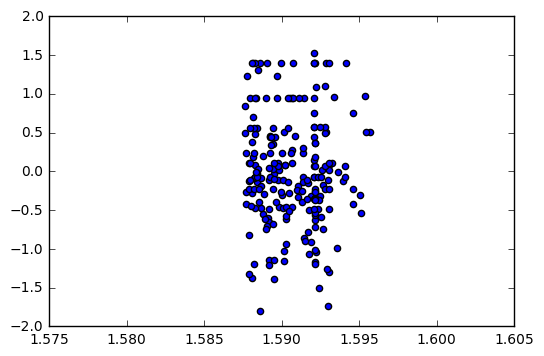

In [33]:
plt.scatter(lasso_grid.predict(user_tr_X), lasso_grid.predict(user_tr_X)-user_tr_Y)

Looks pretty random :)

# Fit the model and predict the missing values

In [34]:
user_pred = pd.read_csv("credit_card_prop_pred.csv", sep=",", index_col="Client")
print(user_pred.shape)

(629, 36)


In [35]:
user_pred_X = user_pred.ix[(user_pred['Sale_CC_pred']==1)]
user_pred_X = user_pred_X.drop('Sale_CC_pred', axis=1)


In [36]:
user_pred_X[skewed_feats] = np.log1p(user_pred_X[skewed_feats])

In [37]:
user_pred_X.head()

,Age,Tenure,M,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Actbal_CA_avg,ActBal_SA_avg,ActBal_MF_avg,ActBal_OVD_avg,ActBal_CC_avg,ActBal_CL_avg
Client,,,,,,,,,,,,,,,,,,,,,
1360,28.0,212,1.0,0.693147,0.000000,0.000000,0.0,0.693147,0.0,6.478344,...,5,0.000000,0,1.386294,649.892143,0.000000,0.00000,0.0,38.785714,0.0
1420,46.0,86,1.0,0.693147,0.000000,0.000000,0.0,0.000000,0.0,5.610892,...,7,0.000000,0,1.945910,272.387857,0.000000,0.00000,0.0,0.000000,0.0
505,38.0,157,1.0,0.693147,1.098612,0.000000,0.0,0.000000,0.0,9.113743,...,1,0.000000,0,0.000000,9078.213571,2.091250,0.00000,0.0,0.000000,0.0
889,36.0,236,1.0,0.693147,0.000000,0.000000,0.0,0.000000,0.0,7.848320,...,3,0.693147,2,0.000000,2560.426429,0.000000,0.00000,0.0,0.000000,0.0
1172,11.0,49,0.0,0.693147,0.693147,0.693147,0.0,0.000000,0.0,7.685354,...,3,0.000000,1,1.098612,2175.241071,81.879643,20497.15893,0.0,0.000000,0.0


In [38]:
user_pred_Y = np.expm1(lasso_grid.predict(user_pred_X[user_tr_X.columns]))

In [39]:
user_pred_Y

array([ 3.92317239,  3.90475787,  3.91512582,  3.92668775,  3.89936353,
        3.91424881,  3.90782217,  3.89703268,  3.90490375,  3.90826008,
        3.90723835,  3.89892641,  3.89557646,  3.90388271,  3.91863544,
        3.90315353,  3.92375811,  3.89368402,  3.91512582,  3.91834287,
        3.91688032,  3.90475787,  3.89586767,  3.91673408,  3.91205697,
        3.89281083,  3.90257026,  3.90446614,  3.91527201,  3.91892802,
        3.91147264,  3.91439497,  3.91249526,  3.89353848,  3.90169549,
        3.89805229,  3.91746529,  3.89281083,  3.91395651,  3.91454113,
        3.89761529,  3.91980586,  3.92009851,  3.91410266,  3.91600299,
        3.92727389,  3.89717832,  3.90432027,  3.90548729,  3.904612  ,
        3.91410266,  3.89936353,  3.91454113,  3.91176479,  3.90840606,
        3.9181966 ,  3.91001213,  3.91103444,  3.89790662,  3.89251981,
        3.91410266,  3.91132657,  3.92507624,  3.9161492 ,  3.91220306,
        3.90373687,  3.91395651,  3.90154971,  3.90826008,  3.90

In [40]:
user_pred = user_pred.ix[(user_pred['Sale_CC_pred']==1)]
user_pred['Sale_CC_pred_value'] = pd.Series(user_pred_Y,index=user_pred.index)

In [41]:
user_pred['Sale_CC_pred_value'].shape

(234,)

In [42]:
user_pred['Sale_CC_pred_value'].describe()

count    234.000000
mean       3.909047
std        0.008848
min        3.892520
25%        3.901841
50%        3.910304
75%        3.915126
max        3.932112
Name: Sale_CC_pred_value, dtype: float64

In [43]:
user_pred.to_csv(path_or_buf='credit_card_prop_pred_value.csv')